In [46]:
import torch
from torch import nn
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import main_ver2 as m
import torch.optim as optim


In [47]:
file = m.FromXVGFile("/largedisk/julius_w/Development/conc2RDF/training_data/rdf20bu.xvg")
file.find_header()
file.get_percentage()
file.read_table()
rvalues = file.rvalues



In [48]:
newdir = m.Directory("/largedisk/julius_w/Development/conc2RDF/training_data")
newset = m.DataSetFromList(newdir.get_relevant_files())
train_conc = [10.0, 30.0, 50.0, 70.0, 90.0]
test_conc = [20.0, 40.0, 60.0, 80.0, 100.0]
train_data = newset.get_subset_from_list(newset.get_indices(train_conc))
test_data = newset.get_subset_from_list(newset.get_indices(test_conc))

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_outputs: int, lr=0.001):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_outputs),
        )
        self.lr = lr
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_losses = []
        self.val_losses = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

    def train_network(self, train_data: m.RdfDataSet, test_data: m.RdfDataSet, epochs=1000, print_progress=False):
        #TODO insert tqdm bar
        for epoch in range(epochs):
            avg_loss = 0.0
            avg_val_loss = 0.0

            """train part"""
            for x, y_ref in train_data:
                self.train()
                y_pred = self(x)
                loss = self.criterion(y_pred, y_ref)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                loss_value = loss.item()
                avg_loss += loss_value

            """test_part"""
            self.eval()
            with torch.no_grad():
                for x, y_ref in test_data:
                    y_pred = self(x)
                    avg_val_loss += self.criterion(y_pred, y_ref)

            avg_loss /= len(train_data[0])
            avg_val_loss /= len(test_data[0])
            self.train_losses.append(avg_loss)
            self.val_losses.append(avg_val_loss)

            if print_progress:
                if (epoch + 1) % 10 == 0:
                    print(
                        f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, Validation Loss: {avg_val_loss:.6f}"
                    )

    def save_model(self):
        torch.save(self, "model.pth")

In [50]:
model = torch.load("model.pth", weights_only=False)

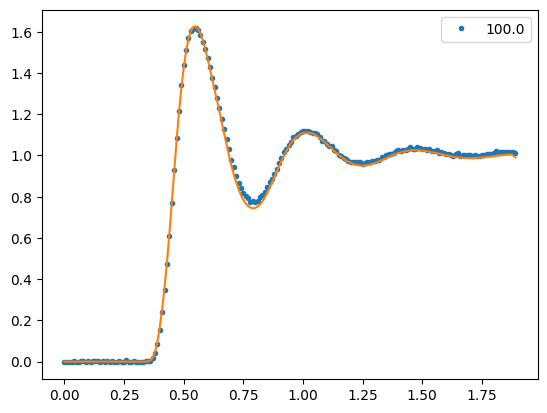

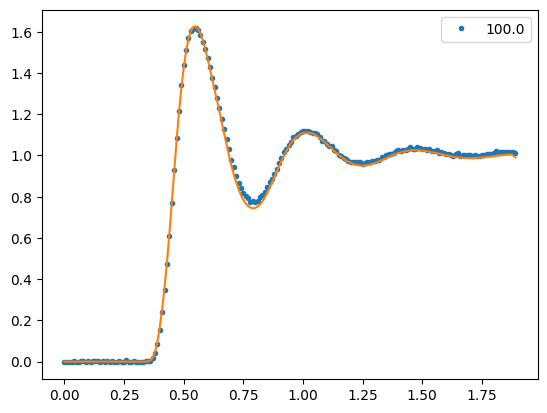

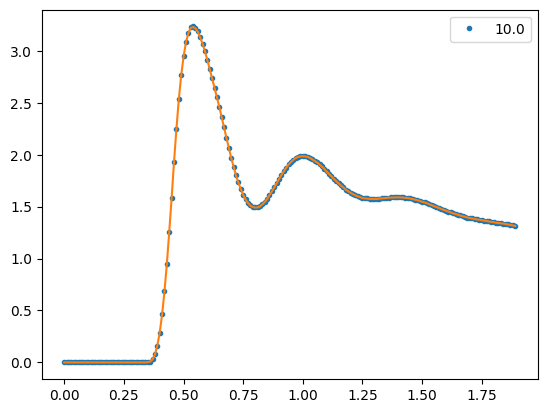

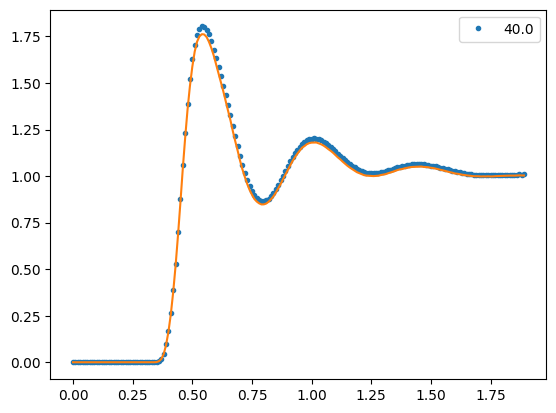

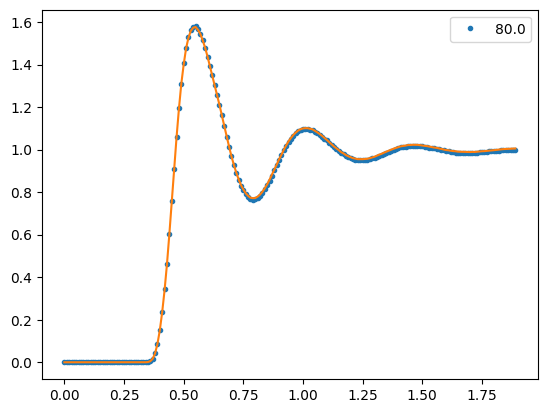

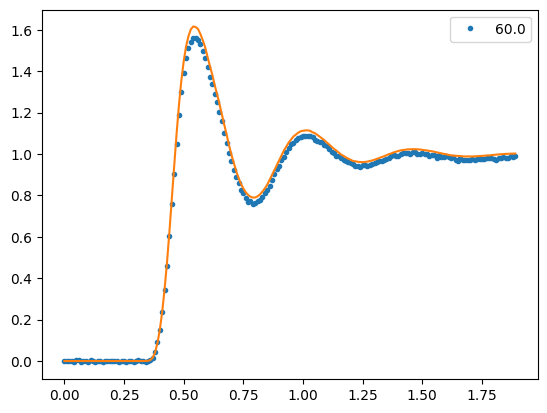

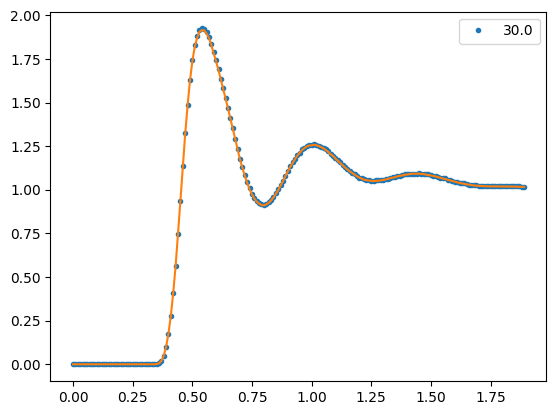

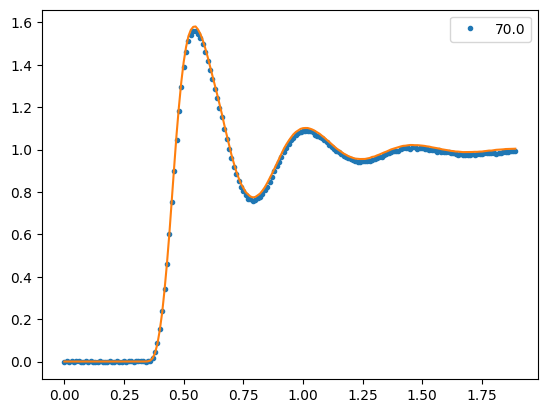

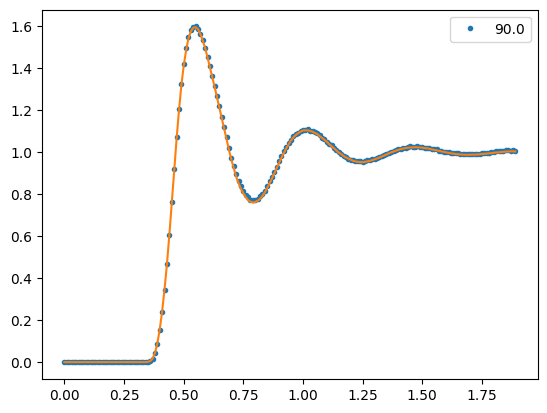

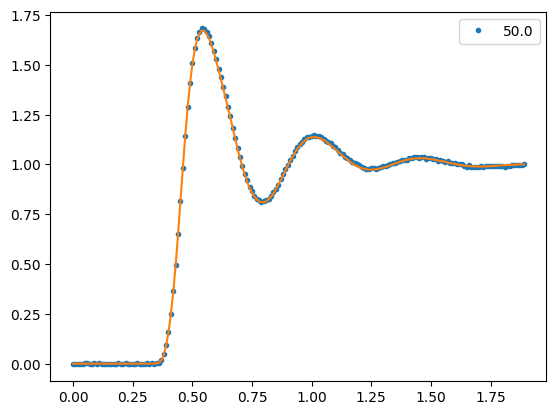

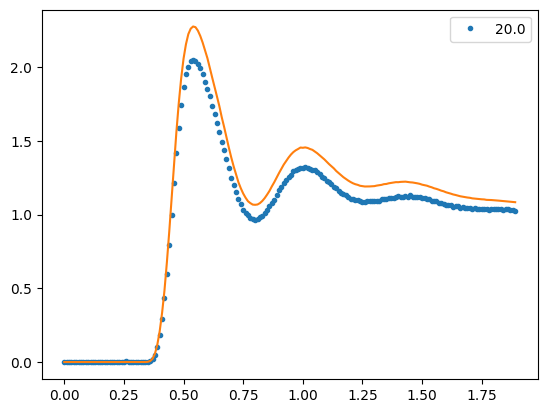

In [51]:
model.eval()
with torch.no_grad():
    for i in range(len(newset.inputs)):
        X = newset.inputs[i]
        pred = model(X)
        plt.plot(rvalues, pred, "o", ms=3, label=f"{X.item()}")
        plt.plot(rvalues, newset.outputs[i])
        plt.legend()
        plt.show()